In [1]:
import numpy as np
import os
import pandas as pd

from tools.compare_functions import load_solutions, get_pareto_front, get_styled_table, classify_solutions
from tools import create_distances
from tools.delete_dominated_solutions import delete_dominated_solutions
from tools.grasp_multiprocessing_MAB import multi_GRASP_Bandit

import multiprocessing
from tqdm import tqdm
from IPython.display import display, HTML
import glob


In [2]:
archive = "WorkSpace 1000_50_5"
k=5
m=50
context_size=3

In [3]:
max_iterations=5

In [4]:
alpha=0.8
betha=0.2
learning_rate=1

In [5]:
create_distances.create_distances(archive)

In [6]:
def ejecutar_con_pool_alpha(archive, k, m, context_size, max_iterations, betha, learning_rate):
    """
    Ejecuta la función multi_GRASP_Bandit 110 veces en paralelo.

    Las ejecuciones se dividen en 11 grupos de 10. Cada grupo tiene un
    valor de alpha diferente, comenzando en 0.0 para el primer grupo y
    aumentando en 0.1 hasta llegar a 1.0 en el último.

    Args:
        archive: El parámetro 'archive' para multi_GRASP_Bandit.
        k: El parámetro 'k' para multi_GRASP_Bandit.
        m: El parámetro 'm' para multi_GRASP_Bandit.
        context_size: El parámetro 'context_size' para multi_GRASP_Bandit.
        max_iterations: El parámetro 'max_iterations' para multi_GRASP_Bandit.
        betha: El parámetro 'betha' para multi_GRASP_Bandit.
        learning_rate: El parámetro 'learning_rate' para multi_GRASP_Bandit.
    """
    # Genera la lista de 11 valores para alpha, de 0.0 a 1.0
    # np.linspace(0, 1, 11) crea [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    alphas = np.linspace(0, 1, 11)
    
    lista_de_argumentos = []
    corrida_id_counter = 1

    # Itera sobre cada valor de alpha
    for alpha_val in alphas:
        # Para cada alpha, crea 10 ejecuciones (corridas)
        for _ in range(10):
            argumentos = (archive, k, m, context_size, max_iterations, alpha_val, betha, learning_rate, corrida_id_counter)
            lista_de_argumentos.append(argumentos)
            corrida_id_counter += 1
            
    # Usa un pool de procesos para ejecutar todas las tareas en paralelo
    with multiprocessing.Pool() as pool:
        # starmap es útil cuando los argumentos de la función son tuplas
        pool.starmap(multi_GRASP_Bandit, lista_de_argumentos)


In [16]:
for i in tqdm(range(100), desc="Ejecutando GRASP"):
    ejecutar_con_pool_alpha(archive, k, m, context_size, max_iterations, betha, learning_rate)

Ejecutando GRASP:  18%|█▊        | 18/100 [01:38<07:29,  5.49s/it]


KeyboardInterrupt: 

In [10]:
import numpy as np
import pandas as pd
import os

def contar_soluciones_en_pareto(archive: str, path_pareto: str, path_soluciones: str, total_corridas: int = 110) -> list:
    """
    Carga un frente de Pareto desde un CSV y cuenta cuántas soluciones de cada 
    archivo de resultados (también CSV) se encuentran en dicho frente, usando 
    solo las columnas 'f1', 'f2' y 'f3'.

    Args:
        archive (str): El nombre base del archivo para construir las rutas de soluciones.
        path_pareto (str): La ruta completa al archivo CSV del frente de Pareto.
        path_soluciones (str): La ruta al directorio que contiene los archivos de soluciones.
        total_corridas (int): El número total de archivos de soluciones a procesar.

    Returns:
        list: Una lista donde cada elemento es el recuento de soluciones
              en el frente de Pareto para el archivo correspondiente.
    """
    
    # 1. Cargar el frente de Pareto de referencia desde un CSV
    try:
        # Leer el archivo CSV completo
        df_pareto = pd.read_csv(path_pareto)
        # Seleccionar solo las columnas de interés y convertir a un array de NumPy
        frente_pareto = df_pareto[['f1', 'f2', 'f3']].values

        print(f"✅ Frente de Pareto cargado desde '{path_pareto}'. Contiene {len(frente_pareto)} soluciones.")
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo del frente de Pareto en '{path_pareto}'.")
        return []
    except KeyError:
        print(f"❌ Error: El archivo '{path_pareto}' no contiene las columnas 'f1', 'f2' y 'f3'.")
        return []
    except Exception as e:
        print(f"❌ Error al leer el archivo del frente de Pareto: {e}")
        return []

    # 2. Iterar a través de cada archivo de solución y contar las coincidencias
    conteo_por_archivo = []
    
    for i in range(1, total_corridas + 1):
        # Construir la ruta para cada archivo CSV de solución
        ruta_solution = f"{path_soluciones}/{archive}_#{i}.csv"
        
        if not os.path.exists(ruta_solution):
            print(f"⚠️  Advertencia: El archivo '{ruta_solution}' no existe. Se contará como 0.")
            conteo_por_archivo.append(0)
            continue

        try:
            # Cargar las soluciones del archivo actual
            df_soluciones = pd.read_csv(ruta_solution)
            # Seleccionar solo las columnas de interés y convertir a NumPy array
            soluciones_actuales = df_soluciones[['f1', 'f2', 'f3']].values
            
            # Contar cuántas soluciones están en el frente de Pareto
            contador = 0
            if soluciones_actuales.size > 0: # Asegurarse de que no está vacío tras seleccionar
                for sol in soluciones_actuales:
                    if any(np.allclose(sol, p_sol, atol=1e-6) for p_sol in frente_pareto):
                        contador += 1
            
            conteo_por_archivo.append(contador)
            
        except pd.errors.EmptyDataError:
            print(f"ℹ️  Info: El archivo '{ruta_solution}' está vacío. Se contará como 0.")
            conteo_por_archivo.append(0)
        except KeyError:
            print(f"⚠️  Advertencia: El archivo '{ruta_solution}' no contiene las columnas 'f1', 'f2' y 'f3'. Se contará como 0.")
            conteo_por_archivo.append(0)
        except Exception as e:
            print(f"❌ Error procesando el archivo '{ruta_solution}': {e}")
            conteo_por_archivo.append(0)

    return conteo_por_archivo


In [13]:
path_pareto = f"Pareto_front/{archive}.csv"
path_soluciones = f"Solutions/Multiprocessing/{archive}"

In [17]:
# Llamar a la función principal (procesará hasta el número 5, aunque solo existan 4)
vector_de_conteos = contar_soluciones_en_pareto(archive, path_pareto, path_soluciones, total_corridas=110)

✅ Frente de Pareto cargado desde 'Pareto_front/WorkSpace 1000_50_5.csv'. Contiene 18 soluciones.


In [18]:
# Imprimir el resultado
print("\n--- RESULTADO FINAL ---")
print("Vector de conteos (soluciones en el frente por archivo):")
print(vector_de_conteos)


--- RESULTADO FINAL ---
Vector de conteos (soluciones en el frente por archivo):
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def graficar_boxplots_por_alpha(vector_de_conteos: list, archive: str):
    """
    Genera una gráfica de boxplots a partir de un vector de conteos.

    La función asume que el vector contiene 110 elementos que corresponden a
    11 grupos de 10 ejecuciones cada uno, donde cada grupo representa un
    valor de alpha de 0.0 a 1.0.

    Args:
        vector_de_conteos (list): La lista de 110 conteos de soluciones.
        archive (str): El nombre base del archivo, usado para el título del gráfico.
    """
    if len(vector_de_conteos) != 110:
        print(f"❌ Error: Se esperaba un vector con 110 elementos, pero se recibieron {len(vector_de_conteos)}.")
        return

    # 1. Preparar los datos para la gráfica
    # Creamos las etiquetas para los 11 grupos de alpha
    alphas = np.linspace(0, 1, 11)  # [0.0, 0.1, ..., 1.0]
    
    # Repetimos cada valor de alpha 10 veces para que coincida con cada conteo
    grupos_alpha = np.repeat(alphas, 10) # [0.0, 0.0, ..., 0.1, 0.1, ..., 1.0]

    # Creamos un DataFrame de Pandas, que es el formato ideal para Seaborn
    df_grafica = pd.DataFrame({
        'Alpha': grupos_alpha,
        'Conteo de Soluciones': vector_de_conteos
    })

    # 2. Crear la gráfica
    sns.set_theme(style="whitegrid")  # Establecer un estilo visual agradable
    plt.figure(figsize=(14, 8))       # Definir el tamaño de la figura

    # Crear el boxplot
    ax = sns.boxplot(x='Alpha', y='Conteo de Soluciones', data=df_grafica, palette="viridis")

    # 3. Personalizar la gráfica
    # Formatear las etiquetas del eje X para que muestren solo un decimal
    ax.set_xticklabels([f'{alpha:.1f}' for alpha in alphas])
    
    plt.title(f'Distribución de Soluciones Encontradas en el Frente de Pareto\n(Instancia: {archive})', fontsize=16)
    plt.xlabel('Valor de Alpha', fontsize=12)
    plt.ylabel('Número de Soluciones en el Frente', fontsize=12)
    plt.tight_layout() # Ajusta el gráfico para que todo encaje bien

    # 4. Mostrar la gráfica
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14120\2683077784.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Alpha', y='Conteo de Soluciones', data=df_grafica, palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_14120\2683077784.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{alpha:.1f}' for alpha in alphas])


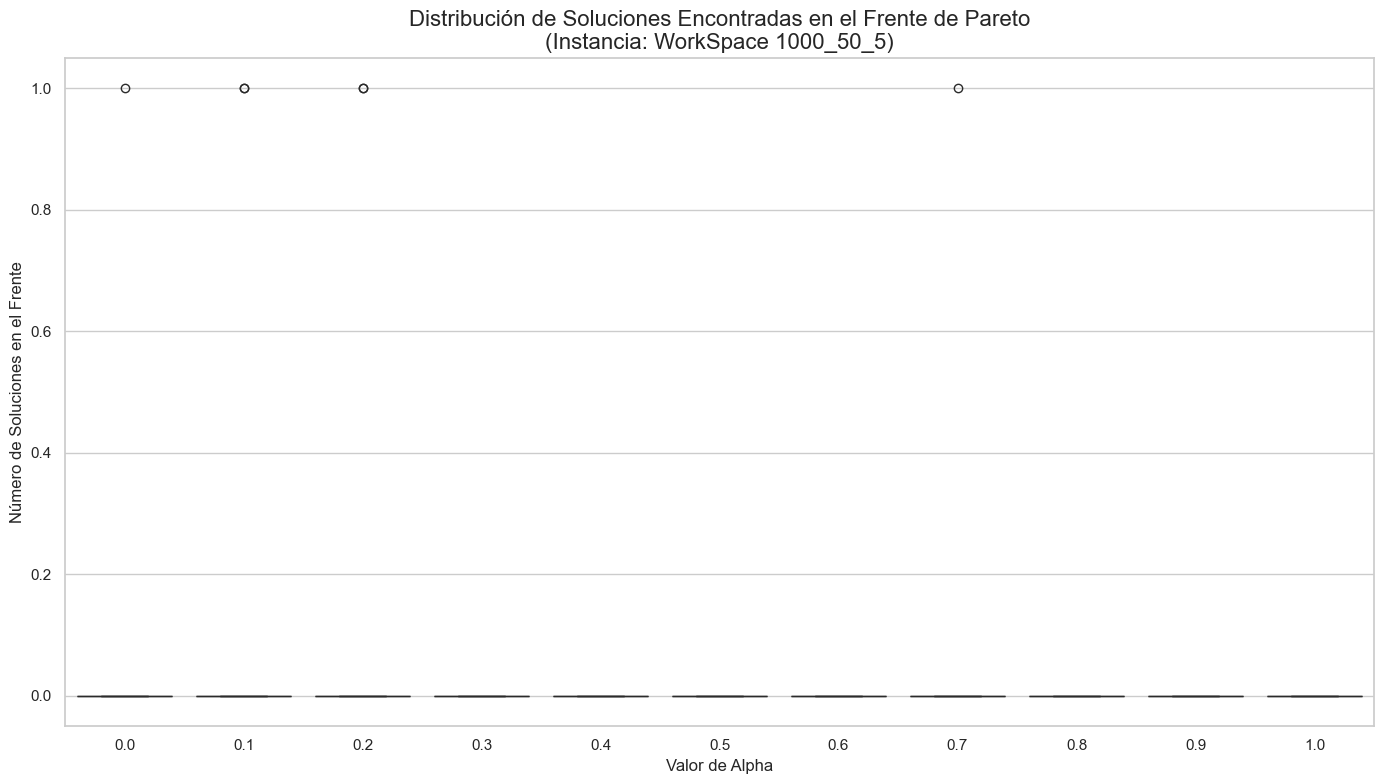

In [23]:
graficar_boxplots_por_alpha(vector_de_conteos, archive)